# Visualizing Height Profiles of Swiss Mountains

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

import meshplot as mp
import plotnine as p9
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

import rasterio
from rasterio.merge import merge
from rasterio.plot import show

import contextily as cx
from pyproj import Transformer

import pymeshlab
from scipy.spatial import Delaunay

import sh
from tqdm.auto import tqdm

## Finding interesting mountains

We can find relevant mountains with metadata and their geographical coordinates by looking at the various lists which [Wikipedia](https://en.wikipedia.org/wiki/Category:Lists_of_mountains_of_Switzerland) provides.

### Retrieve set of "all" mountains

In [2]:
df_mountains = pd.read_html(
    "https://en.wikipedia.org/wiki/List_of_prominent_mountains_of_Switzerland"
)[4]

# it requires some extra engineering to get their latitude and longitude in a useable format
def extract_coords(x):
    lat_raw, lng_raw = x.split(" ")
    return float(lat_raw[1:-2]), float(
        lng_raw[:-2]
    )  # invisible character '\ufeff' in front of lat


df_mountains = df_mountains.assign(
    coords=lambda x: x["Coordinates"].str.split(" / ").str[-1].apply(extract_coords)
)

df_mountains.rename(
    columns={
        "Mountain": "name",
        "Height(m)[2]": "height_m",
        "Prom.(m)[2]": "prominence_m",
    },
    inplace=True,
)

df_mountains = gpd.GeoDataFrame(
    df_mountains,
    geometry=gpd.points_from_xy(
        df_mountains["coords"].str[1], df_mountains["coords"].str[0]
    ),
)
df_mountains.set_crs(epsg=4326, inplace=True)

df_mountains.head()

,Heightrank,Prom.rank,name,height_m,prominence_m,Coordinates,Range,Canton(s),First[5]ascent,coords,geometry
0,1,3,Monte Rosa (Dufourspitze),4634,2165,".mw-parser-output .geo-default,.mw-parser-outp...",Pennine Alps,Valais,1855.0,"(45.93694, 7.86694)",POINT (7.86694 45.93694)
1,2,29,Dom,4545,1046,46°05′38″N 07°51′32″E﻿ / ﻿46.09389°N 7.85889°E,Pennine Alps,Valais,1858.0,"(46.09389, 7.85889)",POINT (7.85889 46.09389)
2,3,302,Lyskamm,4533,381,45°55′20″N 07°50′08″E﻿ / ﻿45.92222°N 7.83556°E,Pennine Alps,Valais,1861.0,"(45.92222, 7.83556)",POINT (7.83556 45.92222)
3,4,18,Weisshorn,4506,1235,46°06′05″N 07°42′57″E﻿ / ﻿46.10139°N 7.71583°E,Pennine Alps,Valais,1861.0,"(46.10139, 7.71583)",POINT (7.71583 46.10139)
4,5,30,Matterhorn,4478,1042,45°58′35″N 07°39′31″E﻿ / ﻿45.97639°N 7.65861°E,Pennine Alps,Valais,1865.0,"(45.97639, 7.65861)",POINT (7.65861 45.97639)


### Basic statistics

We can observe that most mountains (which we retrieved from Wikipedia) have a height of around $3000m$.

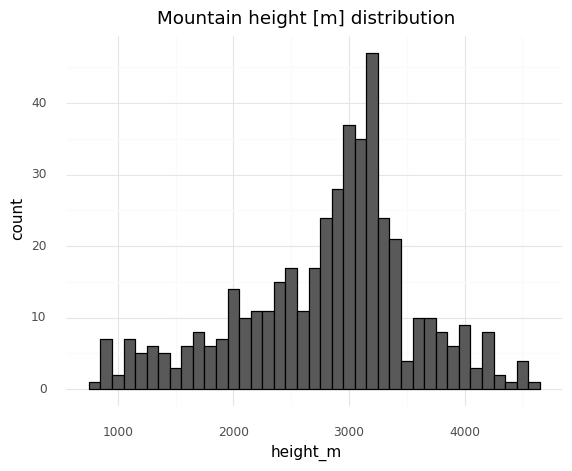

<ggplot: (349572081)>

In [3]:
(
    p9.ggplot(df_mountains, p9.aes(x="height_m"))
    + p9.geom_histogram(binwidth=100, color="black")
    + p9.ggtitle("Mountain height [m] distribution")
    + p9.theme_minimal()
)

Furthermore, most considered mountains have a prominence (height of mountain relative to lowest contour line encircling it but containing no higher summit) of below $500m$.

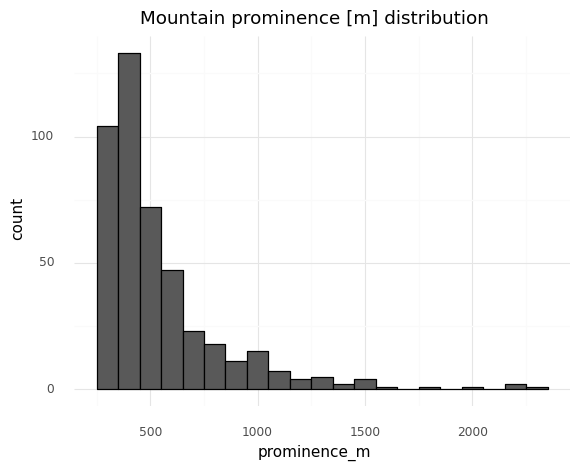

<ggplot: (280496490)>

In [4]:
(
    p9.ggplot(df_mountains, p9.aes(x="prominence_m"))
    + p9.geom_histogram(binwidth=100, color="black")
    + p9.ggtitle("Mountain prominence [m] distribution")
    + p9.theme_minimal()
)

### Subset to interesting mountains

To make the visualization feasible, we'll restrict ourselves to a subset of subjectively interesting mountains.
We consider a mountain to be interesting if it is high, isolated and far away from the border (such that we can obtain the complete height profile of its surrounding region).

In [5]:
# load shape of Switzerland
df_switzerland = gpd.read_file("switzerland.geojson")
df_switzerland.set_crs(epsg=4326, inplace=True)

,id,geometry
0,CH,"POLYGON ((8.57415 47.80745, 8.57642 47.80116, ..."


In [6]:
tmp = df_switzerland.to_crs(epsg=3310).boundary
df_mountains["distance_swiss_border"] = df_mountains.to_crs(epsg=3310).geometry.apply(
    lambda g: tmp.distance(g)
)

df_mountains.sort_values("distance_swiss_border").head()

,Heightrank,Prom.rank,name,height_m,prominence_m,Coordinates,Range,Canton(s),First[5]ascent,coords,geometry,distance_swiss_border
60,61,355,Aouille Tseuque,3554,345,45°55′49″N 07°26′35″E﻿ / ﻿45.93028°N 7.44306°E,Pennine Alps,Valais,NaN,"(45.93028, 7.44306)",POINT (7.44306 45.93028),6.607005
34,35,178,Bouquetins,3838,490,45°58′56″N 07°32′43″E﻿ / ﻿45.98222°N 7.54528°E,Pennine Alps,Valais,1871.0,"(45.98222, 7.54528)",POINT (7.54528 45.98222),7.309605
205,206,384,Gamspleisspitze,3015,328,46°55′54″N 10°14′31″E﻿ / ﻿46.93167°N 10.24194°E,Silvretta Alps,Graubünden,1853.0,"(46.93167, 10.24194)",POINT (10.24194 46.93167),10.232307
137,138,435,Dreiländerspitze,3197,306,46°51′03″N 10°08′41″E﻿ / ﻿46.85083°N 10.14472°E,Silvretta Alps,Graubünden,1853.0,"(46.85083, 10.14472)",POINT (10.14472 46.85083),12.469264
57,58,365,Piz Glüschaint,3594,341,46°21′45″N 09°50′24″E﻿ / ﻿46.36250°N 9.84000°E,Bernina Range,Graubünden,1863.0,"(46.3625, 9.84)",POINT (9.84000 46.36250),13.609412


In [7]:
# only retain mountains well within Switzerland to avoid cutoff height profiles at border
df_mountains = df_mountains[df_mountains["distance_swiss_border"] > 10000]
print(df_mountains.shape)

# only retain high mountains
df_mountains = df_mountains[df_mountains["height_m"] > 3000]
print(df_mountains.shape)

# only retain isolated mountains to emphasize the height profile
df_mountains = df_mountains[df_mountains["prominence_m"] > 1000]
print(df_mountains.shape)

(265, 12)
(99, 12)
(11, 12)


## Mountain Map

We draw a quick map of Switzerland and highlight the selected mountains to get a better feeling for their distribution.

(5.729968359502834, 10.720279079405891, 45.719604942612904, 47.9094409181006)

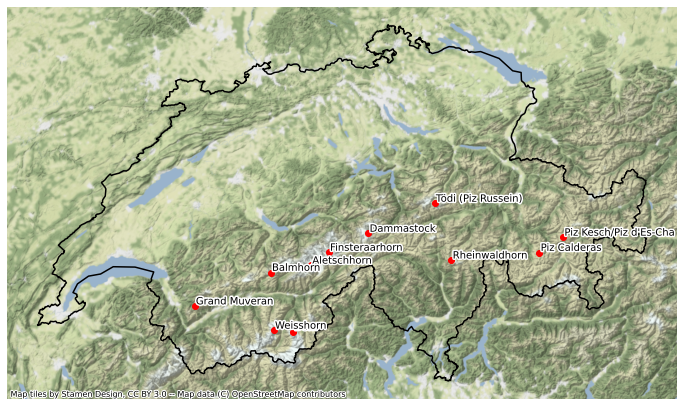

In [8]:
fig, ax = plt.subplots(figsize=(3 * 4, 3 * 3))

df_switzerland.boundary.plot(ax=ax, color="black")
df_mountains.plot(ax=ax, color="red")

cx.add_basemap(
    ax, crs=df_switzerland.crs.to_string(), source=cx.providers.Stamen.TerrainBackground
)

for row in df_mountains.itertuples():
    ax.annotate(
        row.name,
        (row.geometry.x, row.geometry.y),
        (row.geometry.x + 0.01, row.geometry.y + 0.01),
        path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")],
    )

ax.set_aspect(4 / 3)  # cx.add_basemap resets aspect ratio
ax.axis("off")

## Retrieve topological height profiles

Once we have identified all mountains we are interested in, we can retrieve the height profiles of them and their surroundings from the [swissALTI3D](https://www.swisstopo.admin.ch/en/geodata/height/alti3d.html) data resource.

### Helper functions

In [9]:
def download_geotiff(x, y, dest_dir=Path("resources"), year=2020):
    """Helper function to download a GeoTIFF at a given spatial index."""
    dest_dir.mkdir(parents=True, exist_ok=True)

    fname = f"swissalti3d_{year}_{x}-{y}_2_2056_5728.tif"
    target = dest_dir / fname

    if not target.exists():
        url = f"https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_{year}_{x}-{y}/{fname}"

        try:
            sh.wget("-P", str(dest_dir), url, _fg=True)
        except sh.ErrorReturnCode_8:
            if year == 2010:
                print(f"No topolgical data found for coordinates {x}, {y} ({url})")
                return None

            next_year = year - 1
            #             print(f"Warning: {url} does not exist, trying again with previous year ({year} -> {next_year})")
            return download_geotiff(x, y, dest_dir=dest_dir, year=next_year)

    return target


def get_grid(latlong_coords, size=3):
    """Helper function of generate spatial index grid from latitude/longitude coordinates."""
    # infer the grid's spatial coordinates
    dst_crs = rasterio.crs.CRS.from_epsg(2056)
    transformer = Transformer.from_crs("epsg:4326", dst_crs)

    spatial_coords = transformer.transform(*latlong_coords)
    swisstopo_coords = tuple(np.floor(sc / 1000).astype(int) for sc in spatial_coords)

    # generate grid ranges
    x_range = np.arange(swisstopo_coords[0] - size, swisstopo_coords[0] + size)
    y_range = np.arange(swisstopo_coords[1] - size, swisstopo_coords[1] + size)

    # return grid as list of tuples
    grid = np.meshgrid(x_range, y_range)
    return np.append(grid[0].reshape(-1, 1), grid[1].reshape(-1, 1), axis=1)

### Download data

In [10]:
fname_dict = {}
for row in tqdm(
    df_mountains.itertuples(), total=df_mountains.shape[0], desc="Retrieve GeoTIFFs"
):
    mnt = row.name

    grid_coord_list = get_grid(row.coords, size=3)

    fname_dict[mnt] = []
    for x, y in tqdm(grid_coord_list, desc=f"{row.name} {row.coords}"):
        fname = download_geotiff(x, y)

        if fname is not None:
            fname_dict[mnt].append(fname)

Retrieve GeoTIFFs:   0%|          | 0/11 [00:00<?, ?it/s]

Dom (46.09389, 7.85889):   0%|          | 0/36 [00:00<?, ?it/s]

Weisshorn (46.10139, 7.71583):   0%|          | 0/36 [00:00<?, ?it/s]

Finsteraarhorn (46.53722, 8.12611):   0%|          | 0/36 [00:00<?, ?it/s]

Aletschhorn (46.465, 7.99389):   0%|          | 0/36 [00:00<?, ?it/s]

Balmhorn (46.425, 7.69361):   0%|          | 0/36 [00:00<?, ?it/s]

Dammastock (46.64333, 8.42111):   0%|          | 0/36 [00:00<?, ?it/s]

Tödi (Piz Russein) (46.81111, 8.91472):   0%|          | 0/36 [00:00<?, ?it/s]

Piz Kesch/Piz d'Es-Cha (46.62139, 9.87278):   0%|          | 0/36 [00:00<?, ?it/s]

Rheinwaldhorn (46.49361, 9.04028):   0%|          | 0/36 [00:00<?, ?it/s]

Piz Calderas (46.53639, 9.69583):   0%|          | 0/36 [00:00<?, ?it/s]

Grand Muveran (46.23722, 7.12611):   0%|          | 0/36 [00:00<?, ?it/s]

### Read data

In [11]:
def merge_geotiffs(fname_list):
    """Read multiple GeoTIFFs and merge them into single matrix."""
    dataset_list = [rasterio.open(fname) for fname in fname_list]
    mosaic, out_trans = merge(dataset_list)
    mosaic[mosaic == -9999] = np.nan  # clean broken values

    crs_list = [dataset.crs for dataset in dataset_list]
    assert len(set(crs_list)) == 1

    return mosaic, out_trans, crs_list[0]

In [12]:
profile_dict = {}
for mnt, fname_list in tqdm(fname_dict.items(), desc="Merge GeoTIFFs"):
    profile_dict[mnt] = merge_geotiffs(fname_list)

Merge GeoTIFFs:   0%|          | 0/11 [00:00<?, ?it/s]

### Transform data

We will now center each matrix on its point of highest elevation and make a circular cut out.

In [13]:
def get_circle_indices(matrix, radius):
    """Get coordinates of all points falling outside of circle."""
    x0, y0 = np.unravel_index(matrix.argmax(), matrix.shape)

    xs, ys = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    rs = np.sqrt((xs - x0) ** 2 + (ys - y0) ** 2)

    return xs[rs > radius], ys[rs > radius]


def focus_matrix(matrix):
    """Create circular cut out of given matrix."""
    matrix = matrix.copy()

    # set values outside circle to NaN
    xs, ys = get_circle_indices(matrix, 800)
    matrix[xs, ys] = np.nan

    # remove rows/columns which are all NaN now
    matrix = matrix[:, ~np.isnan(matrix).all(axis=0)]
    matrix = matrix[~np.isnan(matrix).all(axis=1), :]

    return matrix

<AxesSubplot:>

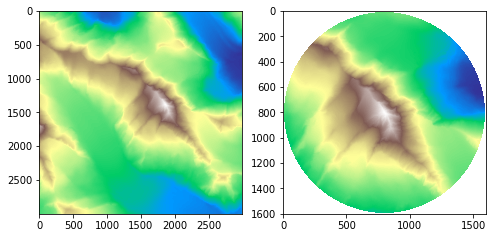

In [14]:
fig, ax_list = plt.subplots(ncols=2, figsize=plt.figaspect(1 / 2))

show(profile_dict["Finsteraarhorn"][0], cmap="terrain", ax=ax_list[0])
show(focus_matrix(profile_dict["Finsteraarhorn"][0][0]), cmap="terrain", ax=ax_list[1])

In [15]:
for mnt in tqdm(profile_dict):
    tmp = (
        focus_matrix(profile_dict[mnt][0][0]),
        profile_dict[mnt][1],
        profile_dict[mnt][2],
    )
    profile_dict[mnt] = tmp

  0%|          | 0/11 [00:00<?, ?it/s]

## Visualize height profiles

### 2D view

We start out with a simple 2D plot of the height profiles and mark the peak height in each center.

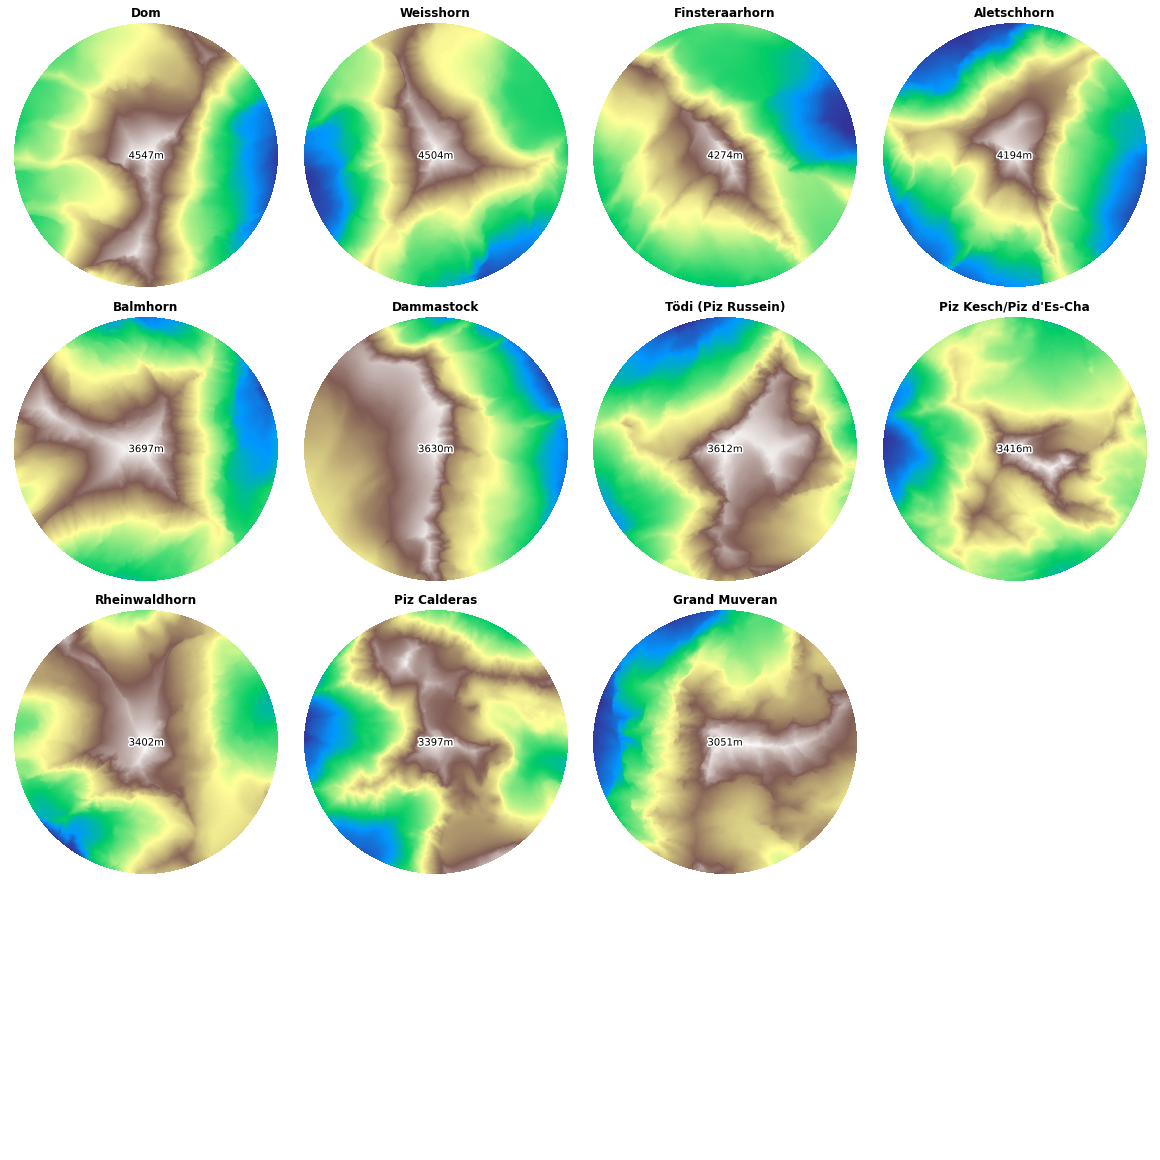

In [16]:
subplot_size = np.ceil(np.sqrt(len(profile_dict))).astype(int)
fig, ax_arr = plt.subplots(
    nrows=subplot_size,
    ncols=subplot_size,
    constrained_layout=True,
    figsize=(subplot_size * 4, subplot_size * 4),
)

[ax.axis("off") for ax in ax_arr.flat]

for (mnt, profile), ax in zip(profile_dict.items(), ax_arr.flat):
    show(profile[0], cmap="terrain", ax=ax, title=mnt)

    max_height = profile[0][profile[0].shape[0] // 2, profile[0].shape[1] // 2]
    ax.annotate(
        f"{round(max_height)}m",
        (profile[0].shape[0] // 2, profile[0].shape[1] // 2),
        path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")],
        ha="center",
        va="center",
    )

### 3D view

A more interactive and appealing visualization can be achieved by creating 3D meshes from the height data.

#### Create vertex and face list

In [17]:
def create_mesh(matrix):
    """Generate vertex, face and color list for given value matrix."""
    # generate vertex list
    vertex_list = []
    for x, y in np.ndindex(matrix.shape):
        if not np.isnan(matrix[x, y]):
            vertex_list.append((x, y, matrix[x, y]))
    vertex_list = np.asarray(vertex_list)

    # generate color list
    color_list = np.asarray(
        [
            matrix[x, y]
            for x, y in np.ndindex(matrix.shape)
            if not np.isnan(matrix[x, y])
        ]
    )

    # generate face list
    dela = Delaunay(vertex_list[:, :2])

    face_list = []
    for tri in dela.simplices:
        face_list.append(tri)
    face_list = np.asarray(face_list)

    # finalize
    return vertex_list, face_list, color_list

In [18]:
mesh_dict = {}
for mnt, (matrix, _, _) in tqdm(profile_dict.items(), desc="Generate meshes"):
    mesh_dict[mnt] = create_mesh(matrix)

Generate meshes:   0%|          | 0/11 [00:00<?, ?it/s]

#### Visualize single mountain mesh

We can then take a closer look at a single mountain.

In [19]:
vertex_list, face_list, color_list = mesh_dict["Finsteraarhorn"]

In [20]:
mp.plot(vertex_list / 100, face_list, c=color_list, shading=dict(colormap="terrain"))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(8.0, 8.0,…

#### Simplify mesh

To be able to render multiple meshes simultaneously in an efficient manner, we simplify their structure (i.e. remove vertices and faces while retaining approximate visual accuracy).

We start by putting all (selected) mountains into a single coordinate system.

In [21]:
mountain_selection = ["Piz Kesch/Piz d'Es-Cha", "Tödi (Piz Russein)", "Finsteraarhorn"]

In [22]:
translation_matrix_dict = {}

next_offset = 0
for mnt, (matrix, _, _) in tqdm(profile_dict.items()):
    if mnt not in mountain_selection:
        continue

    cur_vertices = mesh_dict[mnt][0]
    offset_mat = np.zeros_like(cur_vertices)

    offset_mat[:, 0] = next_offset
    next_offset += matrix.shape[0]

    translation_matrix_dict[mnt] = offset_mat

  0%|          | 0/11 [00:00<?, ?it/s]

In [23]:
all_vertices, all_faces, all_colors = [], [], []

for mnt, (vertex_list, face_list, color_list) in tqdm(mesh_dict.items()):
    if mnt not in mountain_selection:
        continue

    translation_matrix = translation_matrix_dict[mnt]
    translation_matrix[:, -1] = -vertex_list[
        :, -1
    ].min()  # make all mountains start at same height

    all_faces.extend(face_list + len(all_vertices))
    all_vertices.extend(vertex_list + translation_matrix)
    all_colors.extend(color_list)

all_vertices = np.asarray(all_vertices)
all_faces = np.asarray(all_faces)
all_colors = np.asarray(all_colors)

  0%|          | 0/11 [00:00<?, ?it/s]

Next, we use MeshLab to simplify our meshes. For use in other programs, we also save the (simplified) meshes to an OBJ file.

In [24]:
%%time
ms = pymeshlab.MeshSet()

mesh = pymeshlab.Mesh(all_vertices, all_faces)
ms.add_mesh(mesh, "surface")

print(
    "vertices/faces", ms.current_mesh().vertex_number(), ms.current_mesh().face_number()
)
ms.apply_filter(
    "simplification_quadric_edge_collapse_decimation",
    targetperc=0.1,
    preserveboundary=True,
    preservenormal=True,
    preservetopology=True,
    planarquadric=True,
)
print(
    "vertices/faces", ms.current_mesh().vertex_number(), ms.current_mesh().face_number()
)

ms.save_current_mesh("mountain_meshes.obj")

vertices/faces 6031719 12060852
vertices/faces 604335 1206084


CPU times: user 5min 54s, sys: 23 s, total: 6min 17s
Wall time: 6min 18s


In [25]:
all_vertices_simple = ms.current_mesh().vertex_matrix()
all_faces_simple = ms.current_mesh().face_matrix()

#### Visualize multiple mountains at once

Finally, we can explore all our favorite mountains in an interactive, three dimensional landscape.

In [26]:
mp.plot(
    ms.current_mesh().vertex_matrix() / 100,
    ms.current_mesh().face_matrix(),
    c=ms.current_mesh().vertex_matrix()[:, -1],
    shading=dict(colormap="terrain", width=800),
)

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='white', intensi…